In [1]:
import sys

# import from dirs below
sys.path.insert(0, "..")
sys.path.insert(0, "../src")
sys.path.insert(0, "../src/new_generation")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random

from common.params import N, SEED
from graph_generation import generate_city_graph

from new_generation.Mutators import LineMutator, GenotypeMutator
from new_generation.SpecimenCrossers import GenotypeCrosser

## Symulacja

Population     0, best fitness function:           -23.318301, best lines stops count: Counter({5: 10})


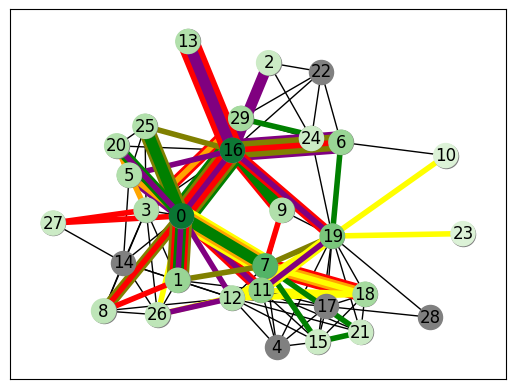

Population   200, best fitness function:            38.001536, best lines stops count: Counter({2: 10, 3: 7, 1: 2, 4: 1})


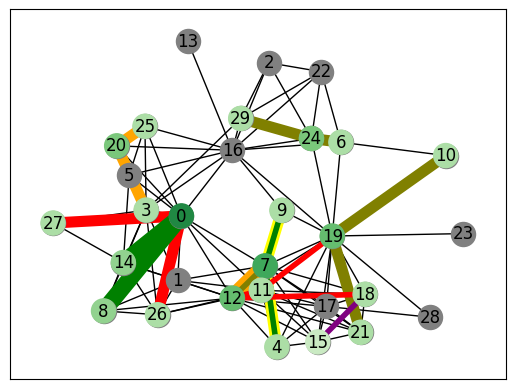

Population   400, best fitness function:            42.479877, best lines stops count: Counter({2: 17, 1: 8, 3: 5, 4: 1})


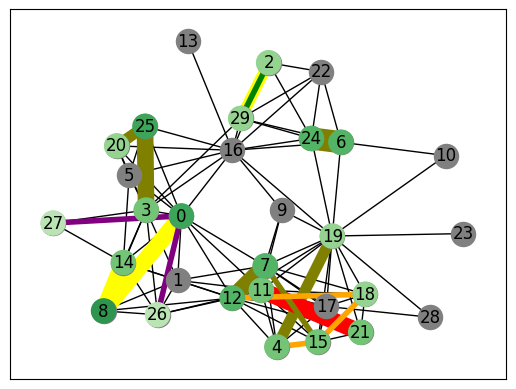

Population   600, best fitness function:            43.245343, best lines stops count: Counter({2: 17, 1: 8, 3: 6, 4: 1})


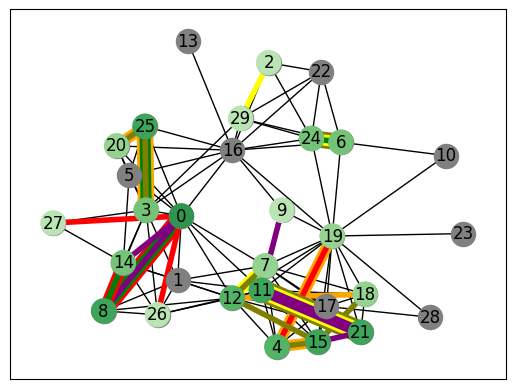

Population   800, best fitness function:            43.788333, best lines stops count: Counter({2: 16, 1: 7, 3: 4, 4: 2})


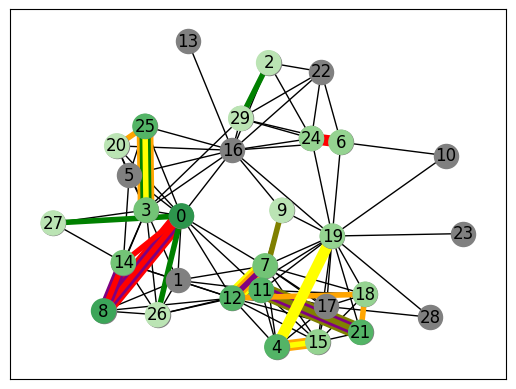

Population  1000, best fitness function:            44.338402, best lines stops count: Counter({2: 15, 1: 5, 3: 4, 4: 3})


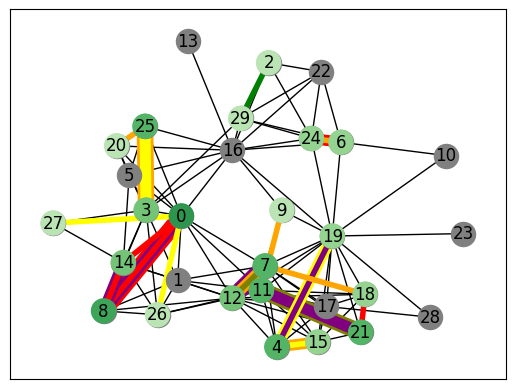

In [4]:
from SimultionEngine import SimulationEngine
from common.params import N_IN_POPULATION
from fitness import fitness
from initial_population import create_initial_population
from new_generation.new_generation_function import new_generation_random
from survival import n_best_survive


random.seed(SEED)

G, best_paths = generate_city_graph(N)

line_mutator = LineMutator(G, best_paths)
genotype_mutator = GenotypeMutator(G, best_paths)
genotype_crosser = GenotypeCrosser(best_paths)

sim_engine = SimulationEngine(
    G,
    initial_population=create_initial_population(G, best_paths),
    fitness_function=fitness,
    survival_function=lambda population: n_best_survive(
        population, N_IN_POPULATION // 5
    ),
    new_generation_function=lambda population, graph: new_generation_random(
        population,
        N_IN_POPULATION,
        line_mutator,
        genotype_mutator,
        genotype_crosser,
    ),
)

sim_engine.run(1000, 200, report_show=True)

Population     0, best fitness function:           -41.054438, best lines stops count: Counter({5: 10})


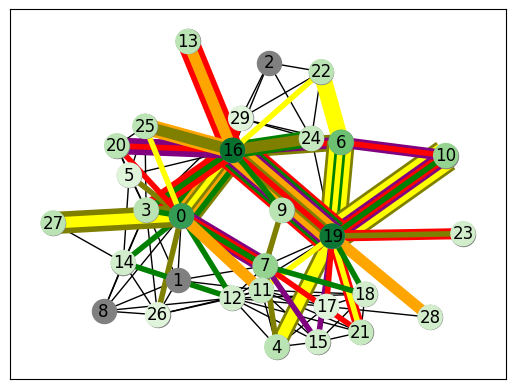

Population   200, best fitness function:            26.136760, best lines stops count: Counter({5: 10})


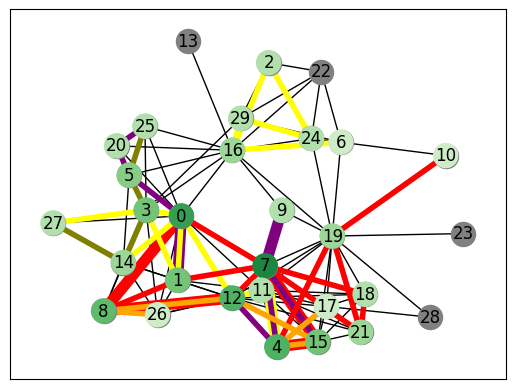

Population   400, best fitness function:            28.907174, best lines stops count: Counter({5: 10})


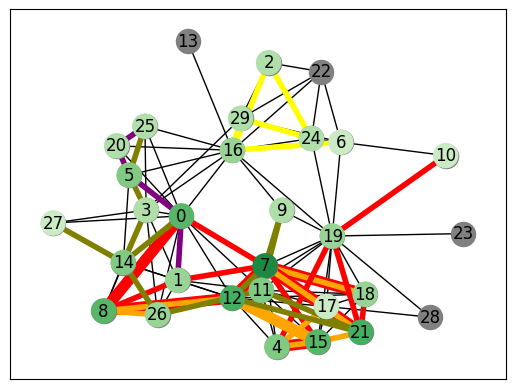

Population   600, best fitness function:            30.216206, best lines stops count: Counter({5: 10})


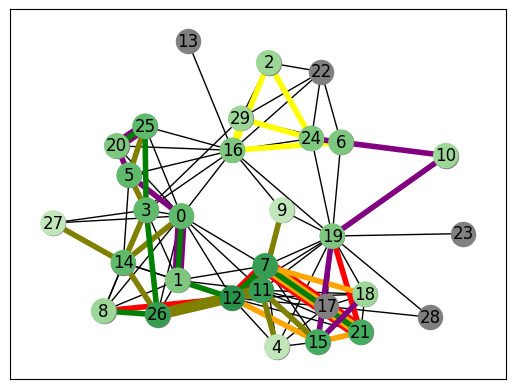

Population   800, best fitness function:            30.797722, best lines stops count: Counter({5: 10})


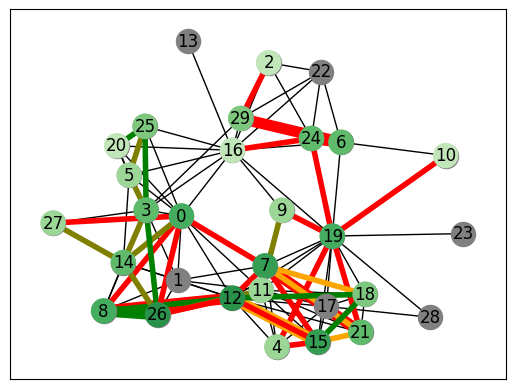

Population  1000, best fitness function:            31.515051, best lines stops count: Counter({5: 10})


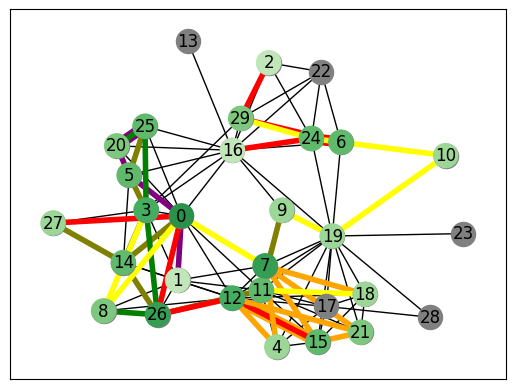

In [5]:
from new_generation.primite_new_generation import new_generation_replace_random_line

sim_engine = SimulationEngine(
    G,
    initial_population=create_initial_population(G, best_paths),
    fitness_function=fitness,
    survival_function=lambda population: n_best_survive(
        population, N_IN_POPULATION // 5
    ),
    new_generation_function=lambda population, graph: new_generation_replace_random_line(
        population, graph, N_IN_POPULATION, best_paths
    ),
)

sim_engine.run(1000, 200, report_show=True)